# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


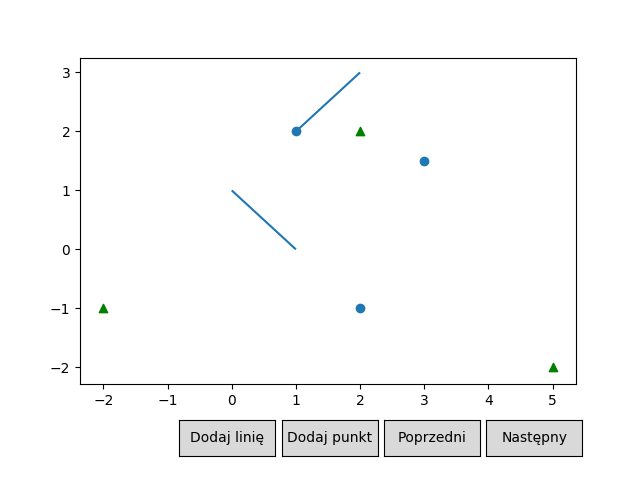

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


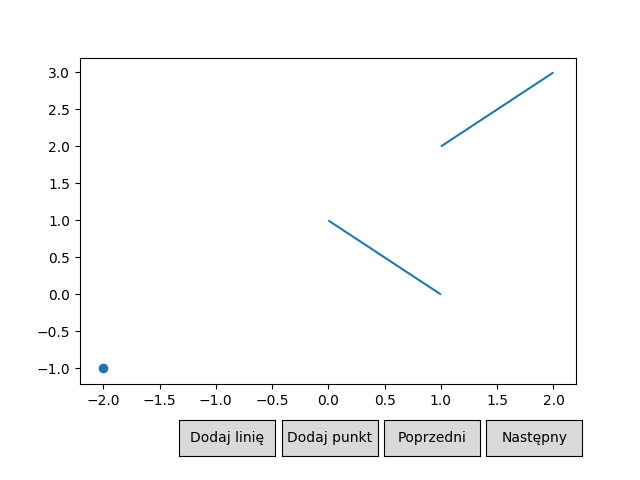

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


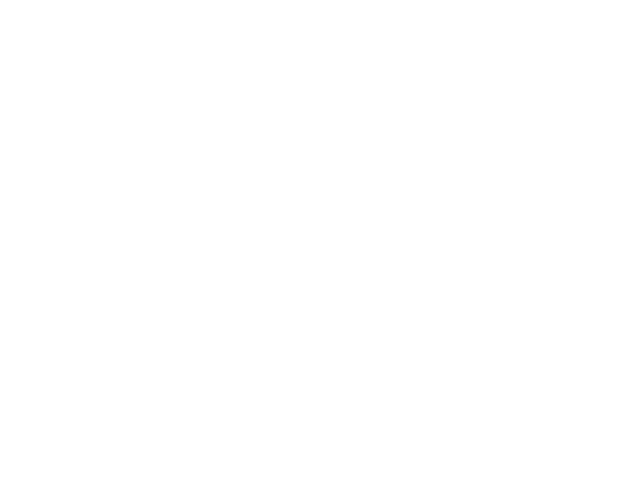

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


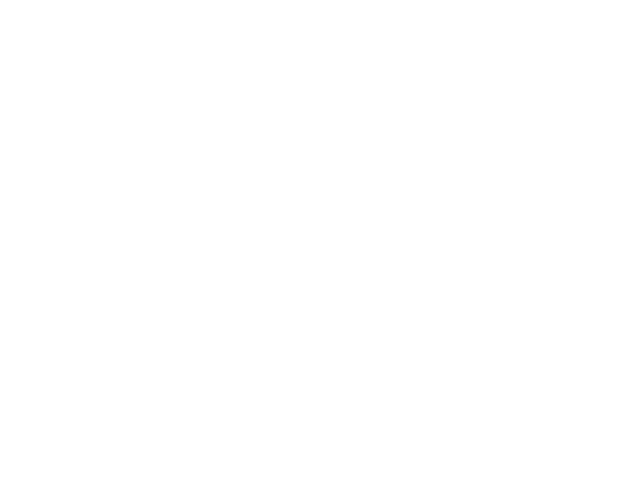

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

### Potrzebne funkcje

In [4]:
import random
import heapq
%matplotlib notebook

scenes = []

def random_lines(number, range_x, range_y):
    lines = []
    once_more = True
    while once_more:
        points = []
        for i in range(number):
            while True:
                point_a = (random.random() * (range_x[1] - range_x[0]) + range_x[0],
                               random.random() * (range_y[1] - range_y[0]) + range_y[0])
                
                point_b = (random.random() * (range_x[1] - range_x[0]) + range_x[0],
                               random.random() * (range_y[1] - range_y[0]) + range_y[0])
                
                if point_a[1] != point_b[1]:
                    points.append(point_a)
                    points.append(point_b)
                    break
                

        for i in range(number):
            line_s, line_e = min(points[2*i], points[2*i+1]), max(points[2*i], points[2*i+1])
            lines.append([line_s, line_e])

        points.sort()

        once_more = False
        for i in range(2*number - 1):
            if points[i] == points[i+1]:
                once_more = True
                break
    
    return lines

def make_linear_func(p1, p2): # zwraca parametry funkcji liniowej, która zawiera odcinek (p1,p2)
    p2, p1 = max(p1, p2), min(p1, p2)
    
    if p2[1] == p1[1]: # pionowy odcinek
        return None
    
    a = (p2[1]-p1[1]) / (p2[0]-p1[0])  # współczynnik kierunkowy
    b = p1[1] - ((p2[1]-p1[1]) * p1[0]) / (p2[0]-p1[0]) # wyraz wolny
    
    return (a, b)

def point_on_line(point_x, line):  # sprawdza czy punkt leży na odcinku czy tylko na jego przedłużeniu
    line = (min(line[0], line[1]), max(line[0], line[1])) # porządkuje punkty odcinka rosnąco (najpierw po x potem po y)
    
    return point_x >= line[0][0] and point_x <= line[1][0] # wystarczy sprawdzić 1 współrzędną

def calculate_eps(range_x, range_y):
    eps = 10 **(-11)
    if (range_x[1] - range_x[0] > 1000):
        eps *= (range_x[1] - range_x[0])//1000
    
    if (range_y[1] - range_y[0] > 1000):
        eps *= (range_y[1] - range_y[0])//1000
        
    return eps
        
def find_intersection(l1, l2): # zwraca przecięcie lub None jeśli go nie ma
    l1_f = make_linear_func(l1[0], l1[1])
    l2_f = make_linear_func(l2[0], l2[1])
    
    # punkt przecięcia
    inter_x = (l2_f[1] - l1_f[1]) / (l1_f[0] - l2_f[0])
    inter_y = l1_f[0] * inter_x + l1_f[1]
    
    # czy punkt leży na odcinkach czy tylko na przedłużeniach
    if point_on_line(inter_x, l1) and point_on_line(inter_x, l2):
        return (inter_x, inter_y)
    else:
        return None   

def det(a, b, c): # 3x3 numpy
    a = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(a)

def draw_lines(lines):
    scenes.append(Scene([], [LinesCollection(lines, color='blue')]))
    
def draw_step(lines, curr_event, broom_range): # wizualizacja kroku algorytmu
    # chcemy zaznaczyć na czerwono punkt w którym ma miejsce obecne zdarzenie
    if curr_event[1] == 's':
        highlighted_point = curr_event[2][0][0]
    elif curr_event[1] == 'e':
        highlighted_point = curr_event[2][0][1]
    else:
        highlighted_point = find_intersection(curr_event[2][0], curr_event[2][1])

    # chcemy narysować miotłę
    broom = [(highlighted_point[0], broom_range[0]), (highlighted_point[0], broom_range[1])]
    
    # dodanie sceny z obecnej iteracji algorytmu
    scenes.append(Scene([PointsCollection([highlighted_point], color='red')], 
                        [LinesCollection(lines, color='blue'), LinesCollection([broom], color='red')]))

def draw_result(lines, result, intersections):
    points = []
    for intersection in result:
        points.append(intersection[0])
    
    if intersections == 0:
        print("nie znaleziono przecięć")
    elif intersections == 1:
        print("znaleziono 1 przecięcie")
    elif (intersections % 10 == 2 or intersections % 10 == 3 or intersections % 10 == 4) and (intersections%100)//10 != 1:
        print("znaleziono {} przecięcia".format(len(points)))
    else:
        print("znaleziono {} przecięć".format(len(points)))    
    
    scenes.append(Scene([PointsCollection(points, color='red')], 
                        [LinesCollection(lines, color='blue')]))

### Instalowanie potrzebnej biblioteki

In [5]:
import sys # do działanie należy wpisać 'pip install sortedcontainers' w wierszu polecenia 
           # i włączyć jeszcze raz jupyter notebook 
%matplotlib notebook
!{sys.executable} -m pip install sortedcontainers

  Using cached https://files.pythonhosted.org/packages/13/f3/cf85f7c3a2dbd1a515d51e1f1676d971abe41bba6f4ab5443240d9a78e5b/sortedcontainers-2.1.0-py2.py3-none-any.whl


### Sprawdzanie istnienia jakiegokolwiek przecięcia

In [6]:
from sortedcontainers import SortedSet


def sweep_line_algorithm_bool(lines_coords, range_x, range_y, visualization=False):
    # zwiększamy epsilon gdy zakres wartości jest duży by program działał poprawnie
    eps = calculate_eps(range_x, range_y)
    curr_x = 0

    class Line:
        def __init__(self, line):
            self.start = min(line[0], line[1])
            self.end = max(line[0], line[1])
            self.a, self.b = make_linear_func(self.start, self.end)

        def __eq__(self, other): # przeciążanie potrzebne do sortowania w SortedList
            return self.start == other.start and self.end == other.end

        def __lt__(self, other): # sprawdza czy dla curr_x obecny odcinek jest pod tym, z którym porównujemy
            self_y = self.a * curr_x + self.b
            other_y = other.a * curr_x + other.b
            
            return self_y < other_y

        def __hash__(self):
            return hash(self.start)
            
        def start_x(self): # początek odcinka
            return self.start[0]

        def end_x(self): # koniec odcinka
            return self.end[0]

        def to_list(self):
            return [self.start, self.end]
    
    def convert_to_objects(lines_coords):
        lines = []
        for line in lines_coords:
            lines.append(Line(line))

        return lines

    lines = convert_to_objects(lines_coords)
    
    events = [] # lista krotek z trzema wartościami: x-owa współrzędna; typ zdarzenia 
                # ('s'-początek odcinka, 'e'-koniec odcinka); odcinek biorący udział (potrzebny do wizualizacji)
        
    state = SortedSet() # struktura stanu pozwalająca na dodawanie, usuwanie i odczytywanie wartości w O(logn)
        
    for line in lines:
        events.append((line.start_x(), 's', [line]))
        events.append((line.end_x(), 'e', [line]))
    
    events.sort() # sortowanie zdarzeń po x-owej współrzędnej
    
    for x, e_type, [line] in events:
        curr_x = x
        
        if visualization:
            draw_step(list(map(Line.to_list, lines)), (x, e_type, [line.to_list()]), range_y)
        
        if e_type == 's': # początek odcinka
            state.add(line) # dodajemy do struktury stanu
            line_index = state.index(line)
            
            if line_index > 0:  # gdy istnieje poprzednik to sprawdzamy przecięcie z obecnym odcinkiem
                prev = state[line_index - 1]
                intersection = find_intersection(line.to_list(), prev.to_list())
                
                if intersection is not None: # znalezione przecięcie
                    if visualization:
                        draw_step(list(map(Line.to_list, lines)), (intersection[0], 'i', [line.to_list(), prev.to_list()]), range_y)
                    return True
            
            if line_index < len(state) - 1: # gdy istnieje następnik to sprawdzamy przecięcie z obecnym odcinkiem
                succ = state[line_index + 1]
                intersection = find_intersection(line.to_list(), succ.to_list())
                
                if intersection is not None:
                    if visualization:
                        draw_step(list(map(Line.to_list, lines)), (intersection[0], 'i', [line.to_list(), succ.to_list()]), range_y)
                    return True
            
        elif e_type == 'e': # koniec odcinka
            line_index = state.index(line)
            
            if line_index > 0 and line_index < len(state) - 1:
                prev = state[line_index - 1] # poprzednik usuwanego odcinka
                succ = state[line_index + 1] # następnik usuwanego odcinka
                intersection = find_intersection(prev.to_list(), succ.to_list())
                
                if intersection is not None:
                    if visualization:
                        draw_step(list(map(Line.to_list, lines)), (intersection[0], 'i', [prev.to_list(), succ.to_list()]), range_y)
                    return True
        
            state.remove(line) # usuwamy ze struktury stanu
    
    return False

### Znajdowanie wszystkich przecięć

In [8]:
def sweep_line_algorithm(lines_coords, range_x, range_y, visualization=False):
    # zwiększamy epsilon gdy zakres wartości jest duży by program działał poprawnie
    eps = calculate_eps(range_x, range_y)
    curr_x = 0

    class Line:
        def __init__(self, line):
            self.start = min(line[0], line[1])
            self.end = max(line[0], line[1])
            self.a, self.b = make_linear_func(self.start, self.end)

        def __eq__(self, other): # przeciążanie potrzebne do sortowania w SortedList
            return self.start == other.start and self.end == other.end

        def __lt__(self, other): # sprawdza czy dla curr_x obecny odcinek jest pod tym, z którym porównujemy
            self_y = self.a * curr_x + self.b
            other_y = other.a * curr_x + other.b
            
            return self_y < other_y
        
        def __hash__(self):
            return hash(self.start)
            
        def start_x(self): # początek odcinka
            return self.start[0]

        def end_x(self): # koniec odcinka
            return self.end[0]

        def to_list(self):
            return [self.start, self.end]
    
    def convert_to_objects(lines_coords):
        lines = []
        for line in lines_coords:
            lines.append(Line(line))

        return lines
    
    lines = convert_to_objects(lines_coords)
    
    events = [] # kopiec minimum krotek z trzema wartościami: x-owa współrzędna; typ zdarzenia 
                # ('s'-początek odcinka, 'e'-koniec odcinka, 'i'-przecięcie odcinków); odcinki biorące udział
        
    state = SortedSet() # struktura stanu pozwalająca na dodawanie, usuwanie i odczytywanie wartości w O(logn)
    
    intersections_pos = SortedSet() # posortowana lista przecięć, by sprawdzić czy dane przecięcie już było brane pod uwagę
    result = [] # lista krotek: (punkt przecięcia, lista odcinków przecinających się)
    
    for line in lines:
        heapq.heappush(events, (line.start[0], 's', [line]))
        heapq.heappush(events, (line.end[0], 'e', [line]))
    
    while len(events) > 0:
        x, e_type, event_lines = heapq.heappop(events)
        curr_x = x # używamy curr_x do porównywania wysokości odcinków
        
        if visualization:
            draw_step(list(map(Line.to_list, lines)), (x, e_type, list(map(Line.to_list, event_lines))), range_y)
        
        if e_type == 's': # początek odcinka
            line = event_lines[0]

            state.add(line) # dodanie odcinka do struktury stanu
            
            line_index = state.index(line)
                
            if line_index > 0:  # gdy istnieje poprzednik to sprawdzamy przecięcie z obecnym odcinkiem
                prev = state[line_index - 1]
                intersection = find_intersection(line.to_list(), prev.to_list())
                
                if intersection is not None:
                    if intersection[0] not in intersections_pos: # sprawdzamy czy takie przecięcie już było znalezione                   
                        heapq.heappush(events, (intersection[0], 'i', [prev, line])) # dodanie zdarzenia przecięcia

                        intersections_pos.add(intersection[0])
                        result.append((intersection, [prev.to_list(), line.to_list()]))
            
            if line_index < len(state) - 1: # gdy istnieje następnym to sprawdzamy przecięcie z obecnym odcinkiem
                succ = state[line_index + 1]
                intersection = find_intersection(line.to_list(), succ.to_list())
                
                if intersection is not None:
                    if intersection[0] not in intersections_pos:                        
                        heapq.heappush(events, (intersection[0], 'i', [line, succ]))

                        intersections_pos.add(intersection[0])
                        result.append((intersection, [line.to_list(), succ.to_list()]))
            
        elif e_type == 'e': # koniec odcinka
            line = event_lines[0]
            
            line_index = state.index(line)
            
            if line_index > 0 and line_index < len(state) - 1:
                prev = state[line_index - 1] # poprzednik usuwanego odcinka
                succ = state[line_index + 1] # następnik usuwanego odcinka
                intersection = find_intersection(prev.to_list(), succ.to_list())
                
                if intersection is not None:
                    if intersection[0] not in intersections_pos:                        
                        heapq.heappush(events, (intersection[0], 'i', [prev, succ]))
                
                        intersections_pos.add(intersection[0])
                        result.append((intersection, [prev.to_list(), succ.to_list()]))
        
            state.remove(line) # usunięcie odcinka ze struktury stanu
            
        elif e_type == 'i': # przecięcie odcinków
            # odcinki biorące udział
            line_1 = event_lines[0] # odcinek, którego początek jest niżej
            line_2 = event_lines[1] # odcinek, którego początek jest wyżej
            
            # przesuwamy naszą miotłę o eps w lewo by móc rozróżnić wysokości przecinających się odcinków
            # w strukturze stanu (by nie były one uważane za ten sam odcinek)
            curr_x -= eps
            
            line_1_index = state.index(line_1)
            line_2_index = state.index(line_2)

            # gdy istnieje poprzednik odcinka którego początek jest niżej to sprawdzamy przecięcie
            # odcinka, którego początek jest wyżej (a koniec niżej) poprzednikiem tego o początku niżej
            if line_1_index > 0:
                prev = state[line_1_index - 1]
                intersection = find_intersection(line_2.to_list(), prev.to_list())
                
                if intersection is not None:
                    if intersection[0] not in intersections_pos:                        
                        heapq.heappush(events, (intersection[0], 'i', [prev, line_2]))

                        intersections_pos.add(intersection[0])
                        result.append((intersection, [prev.to_list(), line_2.to_list()]))
            
            # gdy istnieje następnik odcinka którego początek jest wyżej to sprawdzamy przecięcie
            # odcinka, którego początek jest niżej (a koniec wyżej) z następnikiem tego o początku wyżej
            if line_2_index < len(state) - 1:
                succ = state[line_2_index + 1]
                intersection = find_intersection(line_1.to_list(), succ.to_list())
                
                if intersection is not None:
                    if intersection[0] not in intersections_pos:
                        heapq.heappush(events, (intersection[0], 'i', [line_1, succ]))

                        intersections_pos.add(intersection[0])
                        result.append((intersection, [line_1.to_list(), succ.to_list()]))
            
            # usuwamy odcinki, które się przecinały, by potem wstawić je dla innego curr_x
            state.remove(line_1)
            state.remove(line_2)
            
            # przesuwamy miotłę tak by była eps na prawo od punktu przecięcia
            curr_x += 2*eps
            
            # dodajemy przecinające się odcinki wiedząc że będą teraz popawnie umieszczone w strukturze stanu
            state.add(line_1)
            state.add(line_2)
            
            # powracamy do punktu przecięcia
            curr_x -= eps
    
    return len(result), result

### Wprowadzanie odcinków i wizualizacje

<IPython.core.display.Javascript object>


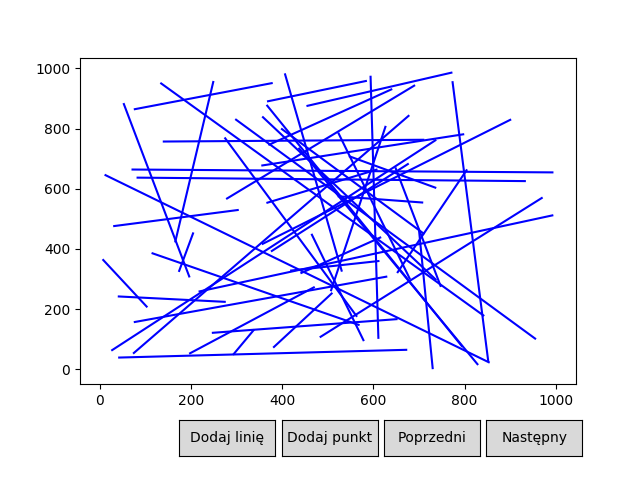

In [9]:
%matplotlib notebook
scenes = []

# zbiór danych
range_x = (0, 1000)
range_y = (0, 1000)
lines = random_lines(50, range_x, range_y) # losowe dodawanie odcinków w zadanym przedziale
#lines = []

draw_lines(lines)

plot = Plot(scenes)
plot.draw()

Znaleziono przecięcie!


<IPython.core.display.Javascript object>


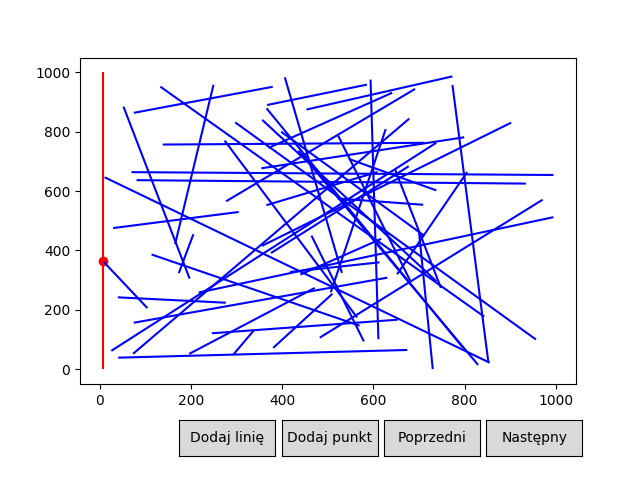

In [10]:
%matplotlib notebook
scenes = []
for line_collection in plot.get_added_lines():
    for line in line_collection.lines:
        lines.append(line)

# algorytm dla znajdowania jakichkolwiek przecięć
result = sweep_line_algorithm_bool(lines, range_x, range_y, visualization=True)
if result:
    print("Znaleziono przecięcie!")
else:
    print("Nie znaleziono przecięcia!")

plot_2 = Plot(scenes)
plot_2.draw()

znaleziono 328 przecięć


<IPython.core.display.Javascript object>


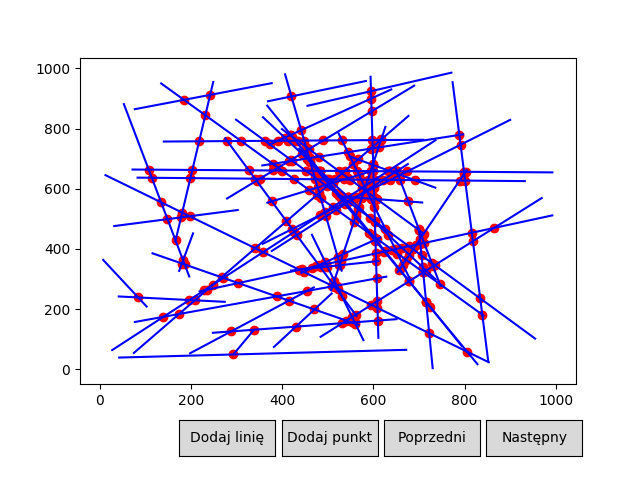

In [11]:
%matplotlib notebook
scenes = []

for line_collection in plot.get_added_lines():
    for line in line_collection.lines:
        lines.append(line)

# algorytm do znajdowania wszystkich przecięć
intersections, result = sweep_line_algorithm(lines, range_x, range_y, visualization=True)
draw_result(lines, result, intersections)

plot_3 = Plot(scenes)
plot_3.draw()